Image deconstruction to seperate individual pixels and bands

Took ~14 min

In [113]:
from PIL import Image
import os
import pandas as pd
import numpy as np

files = list(os.walk("data/"))

columns_of_interest = [
    "Satellite",
    "Correction",
    "WRS",
    "Acquisition Date",
    "Processing Date",
    "Collection",
    "Category",
    "Pixel",
    "Column",
    "Band",
    "Value"
]


image_dataframe = pd.DataFrame(columns=columns_of_interest)
for file in files[0][2]:
    print(file)
    is_tiff = file.split(".")[-1] == "TIF"
    if is_tiff:
        file_contents = file.split("_")
        band = file_contents[7].split(".")[0]
        image_pil = Image.open("/".join(["data", file]))
        image_array = np.array(image_pil)

        rows_to_process = image_array.shape[0]//10
        columns_to_process = image_array.shape[1]//10
        
        image_array = image_array[:rows_to_process, :columns_to_process]
        image_array = pd.DataFrame(image_array, columns=list(range(image_array.shape[1])), index=list(range(image_array.shape[0])))

        image_melted = image_array.melt().reset_index()
        image_melted.columns = ["Pixel", "Column", "Value"]

        image_melted["Satellite"] = file_contents[0]
        image_melted["Correction"] = file_contents[1]
        image_melted["WRS"] = file_contents[2]
        image_melted["Acquisition Date"] = file_contents[3]
        image_melted["Processing Date"] = file_contents[4]
        image_melted["Collection"] = file_contents[5]
        image_melted["Category"] = file_contents[6]
        image_melted["Band"] = band

        image_dataframe = pd.concat([image_dataframe, image_melted])

pixels_grouped = image_dataframe.groupby(by=columns_of_interest[:-2])["Value"].apply(lambda df: df.reset_index(drop=True)).unstack()
pixels_grouped.columns = list(np.add(list(range(7)), 1))
pixels_grouped.reset_index(inplace=True)
print(pixels_grouped.shape)
all_zeroes = [1] * pixels_grouped.shape[0]
for i in range(1, 8, 1):
    all_zeroes = np.logical_and(all_zeroes, pixels_grouped[i] == 0)
pixels_grouped.loc[all_zeroes] = np.nan # zeroes means no data
pixels_grouped = pixels_grouped.dropna()
print(pixels_grouped.shape)

# Domain Knowledge
# https://www.usgs.gov/landsat-missions/landsat-surface-reflectance-derived-spectral-indices

pixels_grouped["NDVI"] = (pixels_grouped[5] - pixels_grouped[4]) / (pixels_grouped[5] + pixels_grouped[4])
pixels_grouped["EVI"] = (pixels_grouped[5] - pixels_grouped[4]) / ((pixels_grouped[5] + pixels_grouped[6]) * pixels_grouped[4] - 7.5 * (pixels_grouped[2] + pixels_grouped[1]))
pixels_grouped["SAVI"] = (pixels_grouped[5] - pixels_grouped[4]) / (pixels_grouped[5] + pixels_grouped[4] + 0.5) * 1.5
pixels_grouped["NDMI"] = (pixels_grouped[5] - pixels_grouped[6]) / (pixels_grouped[5] + pixels_grouped[6])
pixels_grouped["NBR"] = (pixels_grouped[5] - pixels_grouped[7]) / (pixels_grouped[5] + pixels_grouped[7])
pixels_grouped["NBR2"] = (pixels_grouped[6] - pixels_grouped[7]) / (pixels_grouped[6] + pixels_grouped[7])
pixels_grouped["NDSI"] = (pixels_grouped[3] - pixels_grouped[6]) / (pixels_grouped[3] + pixels_grouped[6])

domain_columns = [
    "NDVI",
    "EVI",
    #"SAVI",
    "NDMI",
    "NBR",
    "NBR2",
    "NDSI"
]

LC08_CU_002008_20181108_20210503_02_SR_B1.TIF
LC08_CU_002008_20181108_20210503_02_SR_B2.TIF
LC08_CU_002008_20181108_20210503_02_SR_B3.TIF
LC08_CU_002008_20181108_20210503_02_SR_B4.TIF
LC08_CU_002008_20181108_20210503_02_SR_B5.TIF
LC08_CU_002008_20181108_20210503_02_SR_B6.TIF
LC08_CU_002008_20181108_20210503_02_SR_B7.TIF
(250000, 16)
(159629, 16)


Visualize Data

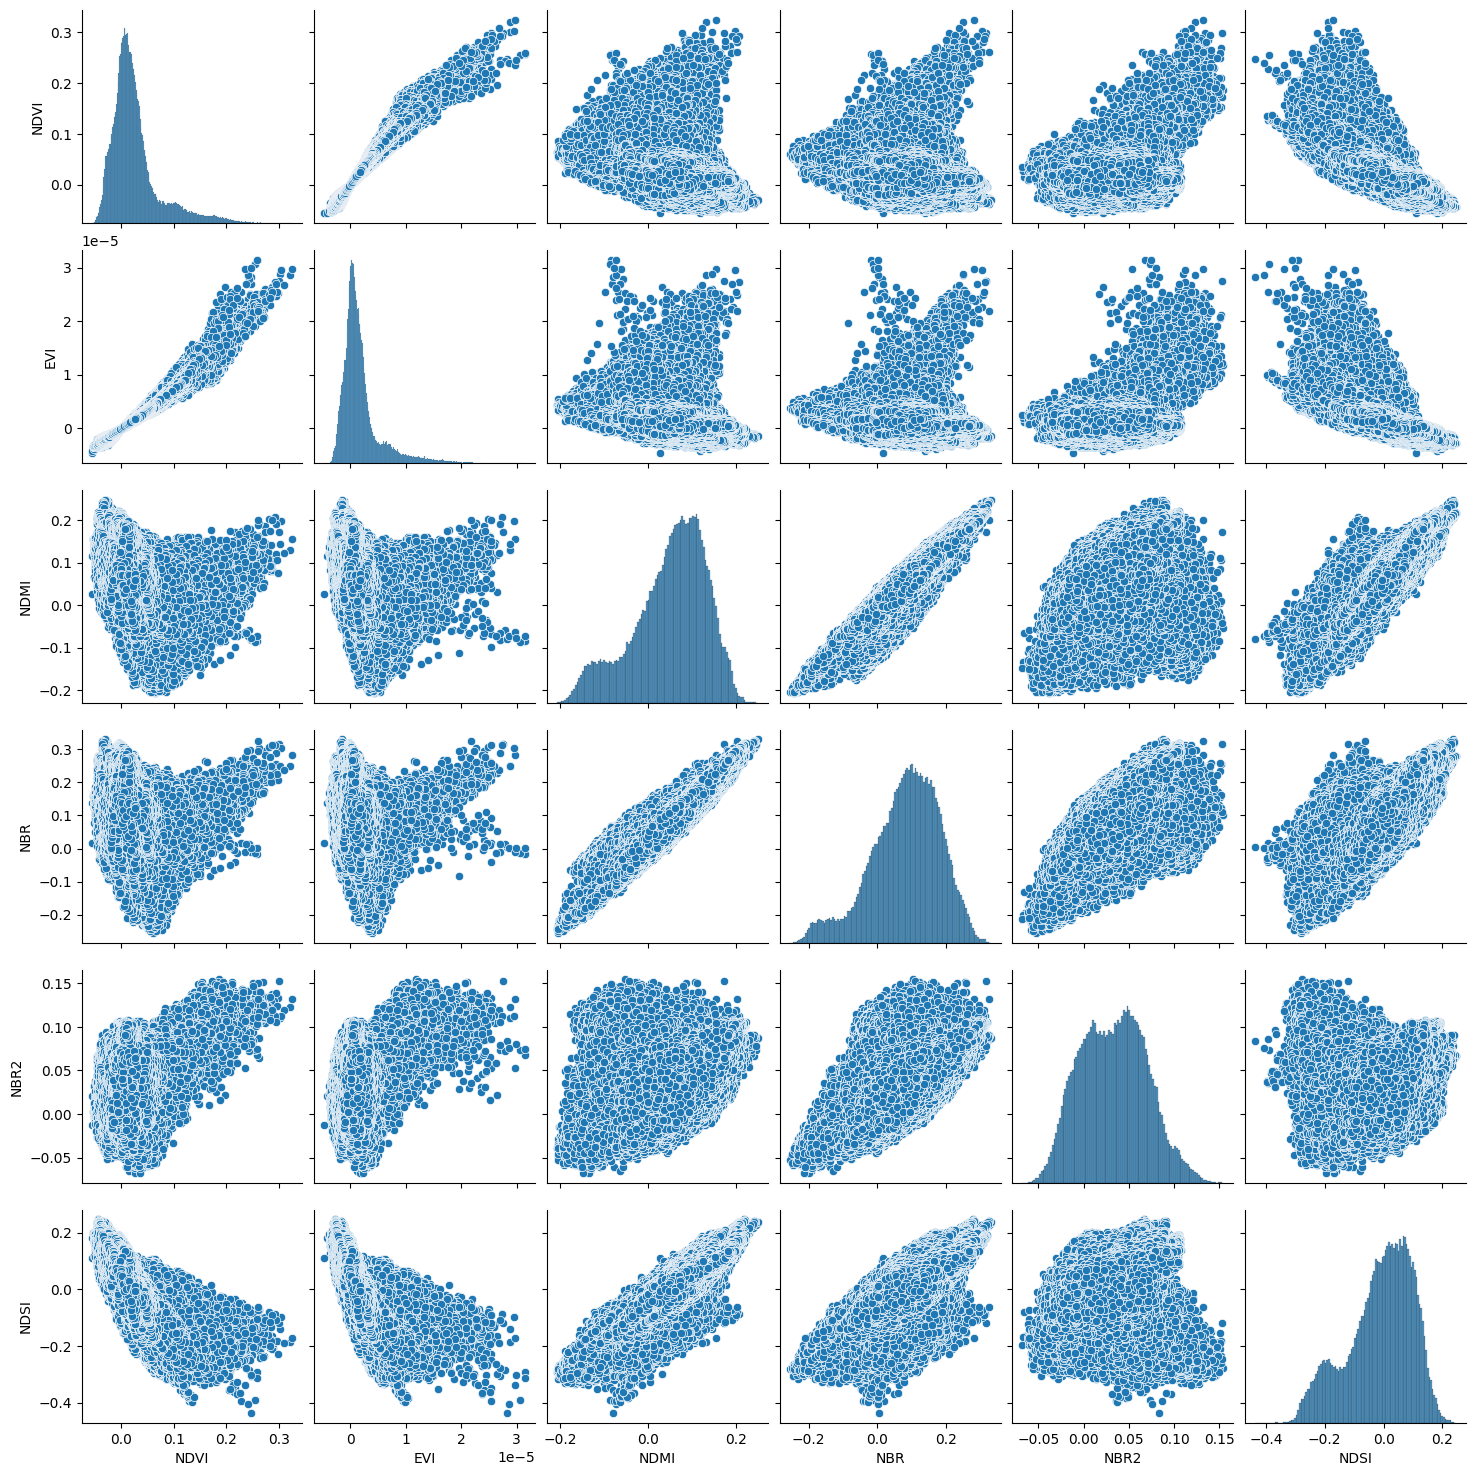

In [114]:
import seaborn

seaborn.pairplot(pixels_grouped[domain_columns])

Simple Model construction

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

param_grid = {'n_clusters':list(range(2, 12, 1))}

best_score = -1
best_params = {}

# Perform grid search
for n_clusters in param_grid['n_clusters']:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels_grouped[domain_columns])
    score = silhouette_score(pixels_grouped[domain_columns], labels)
    print(n_clusters)
    print(score)
    if score > best_score:
        best_score = score
        best_clusters = n_clusters

print("Best parameters:", best_clusters)
print("Best silhouette score:", best_score)
kmeans = KMeans(n_clusters=best_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(pixels_grouped[domain_columns])
pixels_grouped["Kmeans"] = labels


In [ ]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
    
param_grid = {'min_samples':list(range(10,120,10))}
grid = ParameterGrid(param_grid)

best_score = -1
best_params = {}

# Assuming X is your data
for params in grid:
    dbscan = HDBSCAN(**params)
    labels = dbscan.fit_predict(pixels_grouped[domain_columns])
    print(params)
    # Avoid calculating score if there is only one cluster or all points are noise
    if len(set(labels)) > 1:
        score = silhouette_score(pixels_grouped[domain_columns], labels)
        print(score)
        print(np.unique(labels))
        if score > best_score:
            best_score = score
            best_params = params

print("Best parameters:", best_params)
print("Best score:", best_score)
dbscan = HDBSCAN(**best_params)
labels = dbscan.fit_predict(pixels_grouped[domain_columns])
pixels_grouped["HDBSCAN"] = labels



{'min_samples': 10}
0.4654857731030065
[-1  0  1]
{'min_samples': 20}
0.34789799625274576
[-1  0  1  2]
{'min_samples': 30}
0.36065634365941884
[-1  0  1  2]
{'min_samples': 40}
0.4691362738184269
[-1  0  1]
{'min_samples': 50}
0.46782428907608364
[-1  0  1]
{'min_samples': 60}
0.47218906880417283
[-1  0  1]
{'min_samples': 70}
0.471095042813144
[-1  0  1]
{'min_samples': 80}
0.47121729785173
[-1  0  1]
{'min_samples': 90}
0.4714498333289973
[-1  0  1]
{'min_samples': 100}
0.47154940369354803
[-1  0  1]
{'min_samples': 110}
0.47145287118932994
[-1  0  1]
Best parameters: {'min_samples': 60}
Best score: 0.47218906880417283


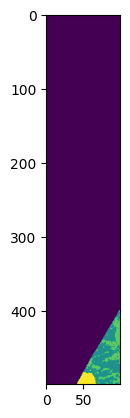

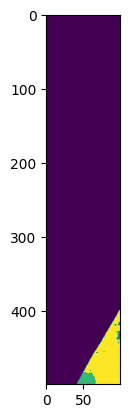

In [ ]:

import matplotlib.pyplot as plt

kmeans_image = np.subtract(np.zeros(image_array.shape), 2)
hdbscan_image = np.subtract(np.zeros(image_array.shape), 2)
for label_id, pixel_id in enumerate(pixels_grouped.index):
    col_id = int(pixels_grouped["Column"][pixel_id])
    row_id = pixel_id - (col_id * len(image_array[1]))
    kmeans_image[row_id, col_id] = pixels_grouped["Kmeans"][pixel_id]
    hdbscan_image[row_id, col_id] = pixels_grouped["HDBSCAN"][pixel_id]

plt.figure()
plt.imshow(kmeans_image)
plt.figure()
plt.imshow(hdbscan_image)

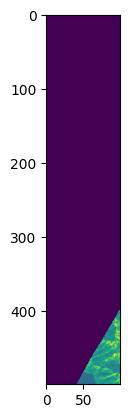

In [ ]:
plt.imshow(image_array)